Fix the seeds

In [1]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
!pip -q install torch
!pip -q install torchvision

In [3]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel mesurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  False 



Here are the functions, which create measurements vectror for all patterns in Hadamard basis

In [4]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [5]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel mesuarements and target images (640 zeros and 640 ones)

In [6]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MesurementDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        self.labels = mnist.targets
        images = torch.cat([mnist.data[mnist.targets == 0][:640], mnist.data[mnist.targets == 1][:640]])
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize(32)])

        self.target_images = transform(images)

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.target_images[indx]

    def __len__(self):
        return len(self.measurements)

In [7]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MesurementDataset(MNIST(root='./MNIST', train=True, download=True))
test_set = MesurementDataset(MNIST(root='./MNIST', train=False, download=True))

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [8]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [9]:
most_important = np.argsort(variance)[-64:]

# Model

In [10]:
!pip -q install pennylane

In [11]:
import pennylane as qml

np.random.seed(0)
torch.manual_seed(0)

num_qubits = int(np.ceil(np.log2(px * px))) # 10

dev = qml.device("default.qubit", wires=num_qubits)

Creating variational quantum circuit

In [12]:
def layer(W):
    for i in range(num_qubits):
        qml.RY(W[i, 0], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])

In [13]:
@qml.qnode(dev, diff_method="backprop", interface="torch")
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, wires=range(6), pad_with=0.0, normalize=True)
    qml.BasisState(np.array([0, 0, 0, 0]), wires=range(6,10))

    for W in weights:
        layer(W)

    return qml.state()

In [14]:
def variational_circuit(q_circuit, params, feat):
    angles = params[0].cpu()
    probs = q_circuit(angles, feat=feat)
    return probs

How it's look like (state preparation, one layer and measurements)

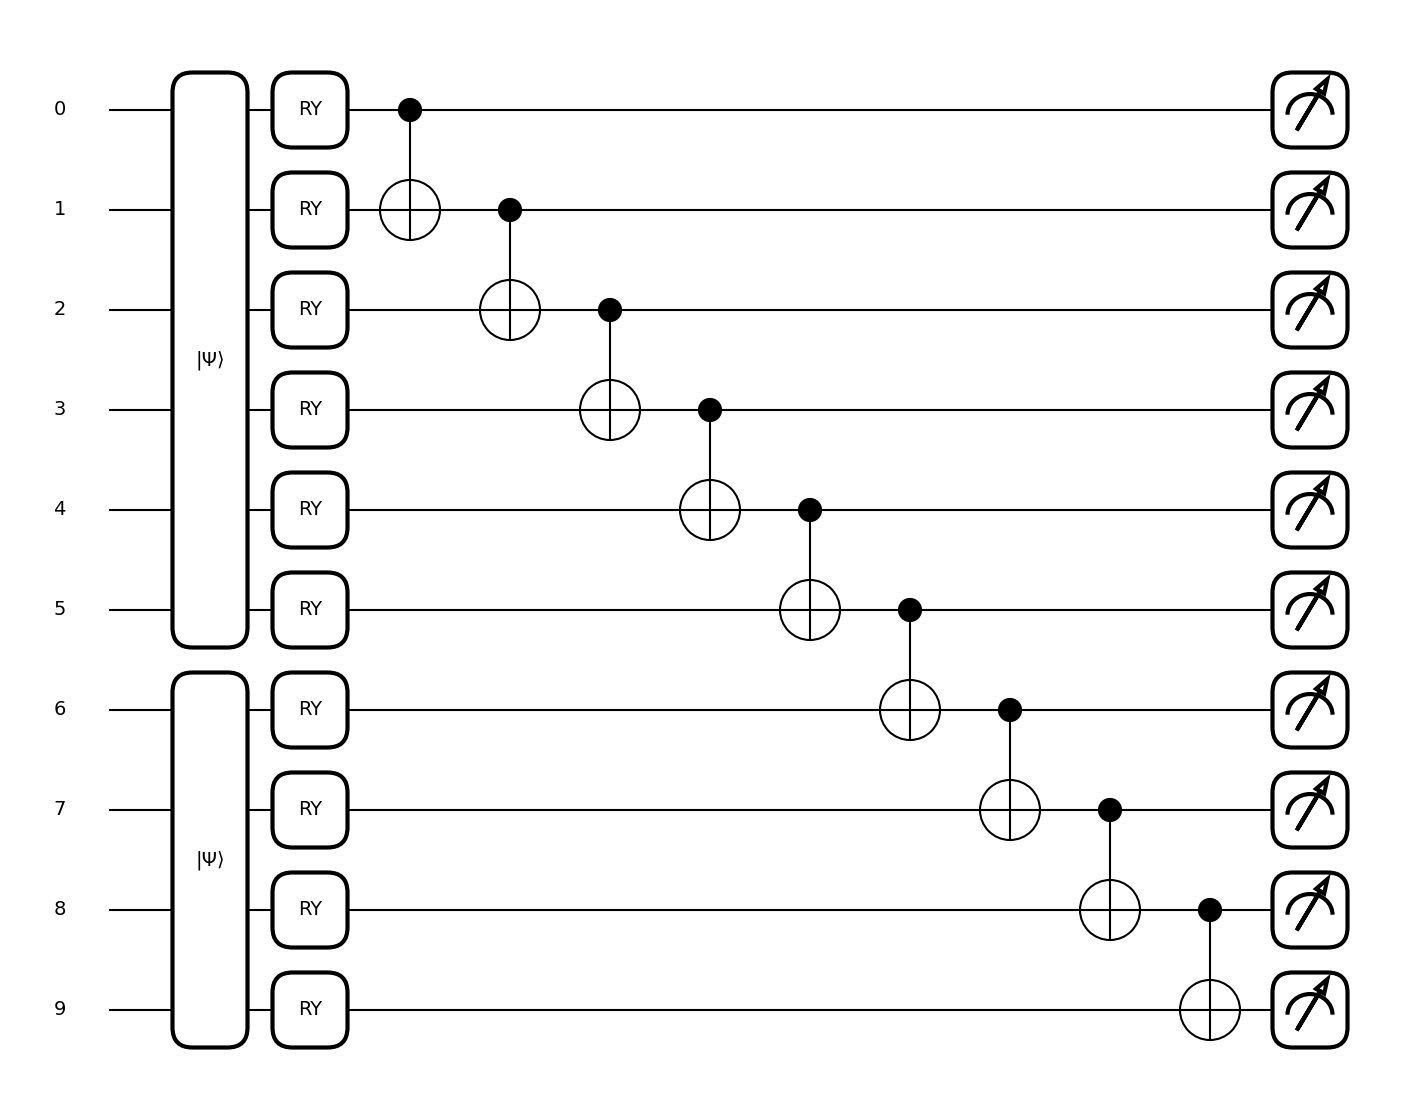

In [15]:
from matplotlib import pyplot as plt
from torch.autograd import Variable

all_weights = Variable(0.1 * torch.randn(1, 10, 1).to(device), requires_grad=True)
features = torch.randn(64)
params = (all_weights,)

fig, ax = qml.draw_mpl(circuit)(params[0], features)
plt.show()

Loss

In [16]:
# make images to be in the same range of values and have the same properties
def target_processing(target_img):
    target_img = target_img.flatten()
    target_img = 2 * target_img - 1
    target_img = torch.nn.functional.normalize(target_img, dim=0)
    return target_img

In [17]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

def loss_function(q_circuit, params, feature_vecs, target_images):
    loss = 0.0
    num_samples = len(target_images)
    for i in range(num_samples):
        process_image = variational_circuit(q_circuit, params, feature_vecs[i].to(device)).float()
        target_image = target_processing(target_images[i].cpu())
        #loss += (1 - torch.matmul(target_image, process_image)) ** 2) # 1 - Fidelity
        #loss += (1 - torch.matmul(target_image, process_image)) # 1 - CosineSimilarity
        loss += torch.sum((target_image - process_image) ** 2) # MSE
        ### SSIM ###
        #process_image = process_image.reshape(32,32).unsqueeze(0).unsqueeze(0)
        #target_image = target_image.reshape(32,32).unsqueeze(0).unsqueeze(0)
        #loss += 1 - StructuralSimilarityIndexMeasure()(process_image, target_image)

    loss /= num_samples

    return loss

Class for plots

In [18]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_plot(self) -> None:
        clear_output()
        n_keys = len(self._history_dict)
        fig, ax = plt.subplots(n_keys, 1, figsize=(12, 3 * n_keys))
        for key_idx, key in enumerate(self._history_dict.keys()):
            history_len = len(self._history_dict[key])
            if n_keys == 1:
                ax.plot(self._history_dict[key], color="c", marker="X")
                ax.set_ylabel(key)
                ax.set_xlabel("step")
            elif n_keys > 1:
                ax[key_idx].plot(self._history_dict[key], color="c", marker="X")
                ax[key_idx].set_ylabel(key)
                ax[key_idx].set_xlabel("step")
                ax[key_idx].set_xticks(np.arange(history_len))
                ax[key_idx].set_xticklabels(np.arange(history_len))
        fig.tight_layout()
        plt.show()

Training (loss plot to the each batch - to monitor the status of training)

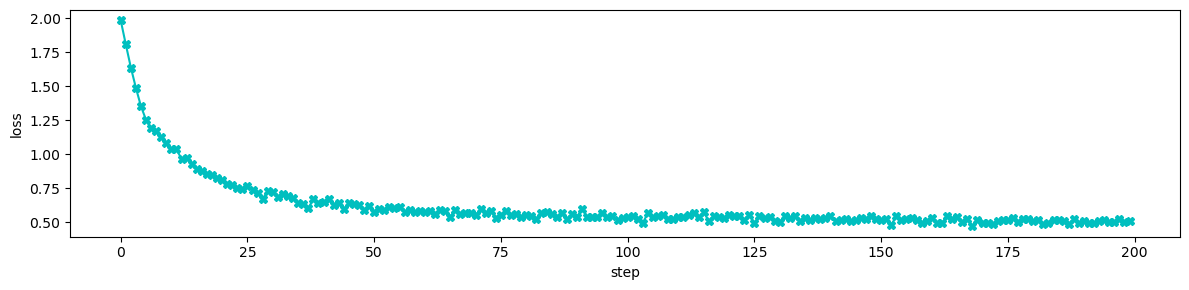

CPU times: user 1h 31min 50s, sys: 46 s, total: 1h 32min 36s
Wall time: 1h 32min 16s


In [19]:
%%time
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch.optim as optim

lr = 0.05
num_layers = 30
num_epoch = 10
device = torch.device("cpu")
pp = ProgressPlotter()

# random parameters initialization
angles = Variable(0.1 * torch.randn(num_layers, num_qubits, 1).cpu(), requires_grad=True)
print("Num params: ", num_layers * num_qubits)

params = (angles,)
optimizer = optim.Adam(params, lr=lr)

q_circuit = qml.QNode(circuit, dev)
batches_num = len(train_loader)

parameters = []
loss_array = []

# train the variational classifier
for e in range(num_epoch):
    loss = 0
    for batch in tqdm(train_loader):
        process_imgs, target_imgs = batch
        process_imgs, target_imgs = process_imgs.cpu(), target_imgs.cpu()

        optimizer.zero_grad()

        curr_cost = loss_function(q_circuit, params, process_imgs[:,most_important], target_imgs)

        curr_cost.backward()
        optimizer.step()

        l = curr_cost.detach().cpu().numpy()
        loss += l

        pp.add_scalar(tag="loss", value=l)
        pp.display_plot()

    loss /= len(train_loader)
    parameters.append(params)
    loss_array.append(loss)

In [22]:
draw_images_0 = []
draw_images_1 = []

measurements_0, target_imgs_0 = next(iter(test_loader))

for batch in test_loader:
    measurements_1, target_imgs_1 = batch

for i in range(batch_size):
    draw_images_0.append(variational_circuit(q_circuit, params, measurements_0[i][most_important].to(device)))
    draw_images_1.append(variational_circuit(q_circuit, params, measurements_1[i][most_important].to(device)))

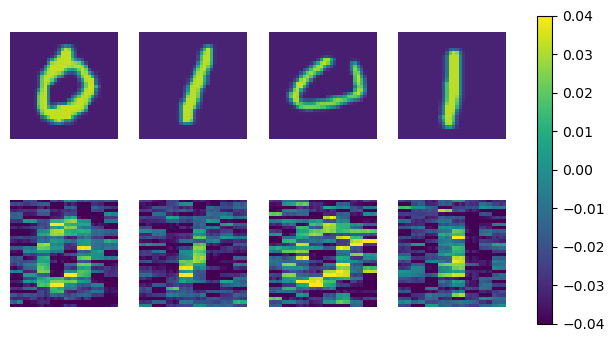

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

targets = [target_imgs_0[0], target_imgs_1[0], target_imgs_0[40], target_imgs_1[61]]
predictions = [draw_images_0[0], draw_images_1[0], draw_images_0[40], draw_images_1[61]]

for i in range(4):
    target_image = target_processing(targets[i])
    axs[0,i].set_axis_off()
    axs[1,i].set_axis_off()
    img = axs[0,i].imshow(target_image.reshape(32,32), vmin=-0.04, vmax=0.04)
    img = axs[1,i].imshow(predictions[i].detach().float().numpy().reshape(32,32), vmin=-0.04, vmax=0.04)
fig.colorbar(img, ax=axs[:,:])

In [24]:
!pip -q install torchmetrics

In [25]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

s = 0
ssim = StructuralSimilarityIndexMeasure()
for i in range(batch_size):
    target_image_0 = target_processing(target_imgs_0[i]).reshape(32,32).unsqueeze(0).unsqueeze(0)
    target_image_1 = target_processing(target_imgs_1[i]).reshape(32,32).unsqueeze(0).unsqueeze(0)
    image_0 = draw_images_0[i].detach().float().reshape(32,32).unsqueeze(0).unsqueeze(0)
    image_1 = draw_images_1[i].detach().float().reshape(32,32).unsqueeze(0).unsqueeze(0)
    s += ssim(image_0, target_image_0)
    s += ssim(image_1, target_image_1)
s /= (2 * batch_size)
s

tensor(0.1512)